In [2]:
import json
import numpy as np
import cv2

In [35]:
pred = json.load(open('/Users/danfengg/Documents/VL-BERT/simmc2/results/devtest/devtest_34.json', 'r'))[0]
lbl = json.load(open('/Users/danfengg/Documents/proc_labels/dev_preprocessed.json', 'r'))['data']

In [13]:
len(pred['label'])

3445

In [14]:
def get_label(objects, answer_choices):
    lb = [0] * len(objects)
    for a in answer_choices:
        lb[objects.index(a)] = 1
    return lb

In [29]:
fp_cum = 0
fn_cum = 0
tp_cum = 0
ct_cum = []
rec = []
for n, lb in enumerate(lbl):
    p = np.asarray(pred['answer_logits'][n])
#     od = np.argsort(p)[-3]
#     p = ((p >= p[od]) * (p >0.4)).astype(int)
    p = ((p >0.5)).astype(int)
    l = np.asarray(get_label(lb['objects'], lb['answer_choices']))
    fp = (p == 1) * (l == 0)
    fp_inds = np.where(fp == 1)[0]
    fp_cum += len(fp_inds)
    tp = (p == 1) * (l == 1)
    tp_inds = np.where(tp == 1)[0]
    tp_cum += len(tp_inds)
    fn = (p == 0) * (l == 1)
    fn_inds = np.where(fn == 1)[0]
    fn_cum += len(fn_inds)
    
    if np.sum(fp) == 0 and np.sum(fn) == 0:
        ct_cum.append(n)
#     if (len(fp_inds) == 0) and (len(fn_inds) == 0):
#         continue
#     if len(tp_inds) == 0:
#         print(lb['question'])
    rec.append({'question': lb['question'], 'img_fn': lb['img_fn'], 'fp_inds': list(fp_inds), 'fp_boxes': [lb['boxes'][i] for i in fp_inds],
               'fn_inds': list(fn_inds), 'fn_boxes': [lb['boxes'][i] for i in fn_inds],
               'tp_inds': list(tp_inds), 'tp_boxes': [lb['boxes'][i] for i in tp_inds],
               'meta': lb['obj_meta'], 'idx':n})
    
print(tp_cum/(tp_cum + fp_cum))
print(tp_cum/(tp_cum + fn_cum))

0.7550811272416738
0.8314839195034794


In [32]:
import os
from matplotlib import pyplot as plt
import textwrap 

img_source = '/Users/danfengg/Documents/data/simmc2_scene_images_dstc10_public'
save_folder = '/Users/danfengg/Documents/VL-BERT/simmc2/results/visualizations'

def bbox_draw(img, boxes, inds, tp, color):
    for i, b in enumerate(boxes):
        left, top, right, bottom = b
        cv2.rectangle(img,(left, top), (right, bottom), color, 2)
        cv2.putText(img, 'box_{} {}'.format(str(inds[i]), tp), (left, top - 12), 0, 1, color, 2)
def attach_text(img, text, tp):
    base = np.ones(img.shape) * 254
    if tp == 'qs':
        splitted_text = ['[' + i for i in text.split('[')[1:]]
        wrapped_text = []
        for i in splitted_text:
            wrapped_text += textwrap.wrap(i, width=100)
    else:
        wrapped_text = text
    for i, line in enumerate(wrapped_text):
        textsize = cv2.getTextSize(line, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)[0]
        gap = textsize[1] + 12
        if tp == 'qs':
            y = 40 + i * gap
        else:
            y = img.shape[0] - i * gap - 40
        x = 40
        cv2.putText(base, line, (x, y), cv2.FONT_HERSHEY_SIMPLEX,
                    1, 
                    (0,0,0), 
                    2, 
                    lineType = cv2.LINE_AA,
                    bottomLeftOrigin=False)
    return base
    

for idx, r in enumerate(rec):
    img_path = os.path.join(img_source, r['img_fn'] + '.png')
    if os.path.isfile(img_path):
        img = cv2.imread(img_path)
    elif os.path.isfile(img_path.replace('m_', '')):
        img = cv2.imread(img_path.replace('m_', ''))
    else:
        raise ValueError()
    bbox_draw(img, r['tp_boxes'], r['tp_inds'], 'tp', (0,255,0))
    bbox_draw(img, r['fp_boxes'], r['fp_inds'], 'fp', (255,0,0))
    bbox_draw(img, r['fn_boxes'], r['fn_inds'], 'fn', (0,0,255))
#     bbox_draw(img, r['tp_boxes'] + r['fn_boxes'], r['tp_inds'] + r['fn_inds'], 'gt', (0,255,0))
    if idx in ct_cum:
        continue
    gt_inds = r['tp_inds'] + r['fn_inds']
    qs = r['question']
    if 'expensive' not in qs:
        continue
    qs_box = attach_text(img, qs, 'qs')
    x, _, _ = np.where(qs_box == 0)
    qs_box = qs_box[:np.max(x), :, :].astype(np.uint8)
    all_inds = list(r['tp_inds']) + list(r['fp_inds']) + list(r['fn_inds'])
    all_inds = gt_inds
#     metas = ['box_{}(GT) '.format(str(i))+r['meta'][i] if i in gt_inds else 'box_{} '.format(str(i))+r['meta'][i] for i in sorted(all_inds)]
#     meta_box = attach_text(img, metas, 'meta')
#     x, _, _ = np.where(meta_box == 0)
#     meta_box = meta_box[np.min(x):, :, :].astype(np.uint8)
#     merge_img = cv2.vconcat([qs_box, meta_box, img])
    merge_img = cv2.vconcat([qs_box, img])
    cv2.imwrite(os.path.join(save_folder, 'visualization_{}.png'.format(idx)), merge_img)
#     cv2.imwrite(os.path.join(save_folder, 'qsbox_{}.png'.format(idx)), qs_box)
#     cv2.imwrite(os.path.join(save_folder, 'metabox_{}.png'.format(idx)), meta_box)
    

In [206]:
pl = ['left', 'right', 'top', 'bottom', 'close', 'back', 'front', 'next to', 'close to', 'far']
obj_pool = ['rack', 'closet', 'wall', 'shel', 'carousel', 'table', 'mirror', 'cubicle', 'row', 'cupboard', 
            'floor stand', 'compartment', 'cabinet', 'cubby', 'cubbies', 'the display', 'slot', 'circular display',
           'mannequin', 'division', 'section']

def find_all(a_str, sub):
    start = 0
    while True:
        start = a_str.find(sub, start)
        if start == -1: return
        yield start
        start += len(sub) # use start += 1 to find overlapping matches
        
def check_prev(s):
    ind = list(find_all(s, '[QRY]'))[-1]
    s = s[ind:]
    for w in ['both', 'them', 'suggested', 'mentioned', 'recommended', 'those', 'take it', 'add it']:
        if w in s:
            return True
    return False

def check_obj(s):
    ind = list(find_all(s, '[QRY]'))[-1]
    s = s[ind:]
    for o in obj_pool:
        if o in s:
            return True
    return False
def check_dir(s):
    ind = list(find_all(s, '[QRY]'))[-1]
    s = s[ind:]
    for d in pl:
        if (d in s) and ('lright' not in s):
            return True
    return False
def update_rec(rec, r):
    rec['tp'] = rec['tp'] + len(r['tp_inds'])
    rec['fp'] = rec['fp'] + len(r['fp_inds'])
    rec['fn'] = rec['fn'] + len(r['fn_inds'])
    rec['ct'] = rec['ct'] + 1
    rec['rec'].append(r['idx'])
    return rec
def compute_scores(rec):
    print('precision', rec['tp'] / (rec['tp'] + rec['fp']))
    print('recall', rec['tp'] / (rec['tp'] + rec['fn']))
obj = {'tp':0, 'fp':0, 'fn':0, 'ct':0, 'rec':[]}
pos = {'tp':0, 'fp':0, 'fn':0, 'ct':0, 'rec':[]}
other = {'tp':0, 'fp':0, 'fn':0, 'ct':0, 'rec':[]}
prev = {'tp':0, 'fp':0, 'fn':0, 'ct':0, 'rec':[]}
idr = []
for idx, r in enumerate(rec):
#     if (len(r['fp_inds']) != 0) or (len(r['fn_inds']) != 0):
    qs = r['question']
    if check_obj(qs):
        update_rec(obj, r)
    if check_prev(qs):
        update_rec(prev, r)
    if check_dir(qs):
        update_rec(pos, r)
    if (not check_obj(qs)) and (not check_prev(qs)) and (not check_dir(qs)):
        idr.append(idx)
#         print(r['question'])
        update_rec(other, r)
total = pos['ct'] + obj['ct'] + prev['ct'] + other['ct']
print('Positional err', pos['ct'], pos['ct']/total)
compute_scores(pos)
print('Non-tgt objs', obj['ct'], obj['ct']/total)
compute_scores(obj)
print('Previously mentioend objs', prev['ct'], prev['ct']/total)
compute_scores(prev)
print('Other', other['ct'], other['ct']/total)
compute_scores(other)

Positional err 365 0.37745604963805585
precision 0.5025
recall 0.6848381601362862
Non-tgt objs 328 0.3391933815925543
precision 0.5093085106382979
recall 0.7053406998158379
Previously mentioend objs 91 0.09410548086866598
precision 0.525
recall 0.6521739130434783
Other 183 0.1892450879007239
precision 0.5052910052910053
recall 0.6631944444444444


In [42]:
pred1 = json.load(open('/Users/danfengg/Documents/VL-BERT/simmc2/results/dev/results_pretrain+gcn.json', 'r'))[0]
pred2 = json.load(open('/Users/danfengg/Documents/VL-BERT/simmc2/results/dev/results_pretrain+gcn+ml.json', 'r'))[0]
rec = []
rec_worse = []
eql = 0
worse = 0
for n, lb in enumerate(lbl):
    p1 = np.asarray(pred1['answer_logits'][n])
    p1 = ((p1 >0.5)).astype(int)
    p2 = np.asarray(pred2['answer_logits'][n])
    p2 = ((p2 >0.5)).astype(int)    
    l = np.asarray(get_label(lb['objects'], lb['answer_choices']))
    accu1 = np.mean(p1==l)
    accu2 = np.mean(p2==l)
    if accu1 < accu2:
        rec.append({'question': lb['question'], 'img_fn': lb['img_fn'], 'meta': lb['obj_meta'], 'idx':n, 'inc':accu2-accu1})
    elif accu1 == accu2:
        eql += 1
    else:
        rec_worse.append({'question': lb['question'], 'img_fn': lb['img_fn'], 'meta': lb['obj_meta'], 'idx':n, 'inc':accu2-accu1})
        worse += 1
print(len(rec), eql, worse)

324 965 113


In [43]:
import pandas as pd
df = pd.DataFrame(rec)
df.sort_values('inc')

,question,img_fn,meta,idx,inc
145,"[USER] Hi, I'm looking for a new jacket today....",cloth_store_paul_12_5,[Customer review score 4.9. brand Cats Are Gre...,713,0.009346
148,[USER] Hello. Please show me to your cheap hoo...,cloth_store_paul_12_5,[Customer review score 4.9. brand Cats Are Gre...,717,0.009346
150,"[USER] Hey, could you tell me something? Whic...",cloth_store_paul_12_5,[Customer review score 4.9. brand Cats Are Gre...,719,0.009346
275,[USER] I need some cheap trousers with good re...,cloth_store_paul_19_9,[Customer review score 3.0. brand Pedals & Gea...,1215,0.009434
274,[USER] I'd like to see joggers please. [SYS] I...,cloth_store_paul_19_9,[Customer review score 3.0. brand Pedals & Gea...,1213,0.009434
...,...,...,...,...,...
233,[USER] I changed my mind. Do you have anythin...,cloth_store_3_1_5,[Customer review score 2.6. brand 212 Local. P...,1057,0.233333
196,"[USER] That's neat, but do you have anything e...",cloth_store_1498649_woman_10_5,[Customer review score 3.9. brand Pedals & Gea...,922,0.285714
24,[USER] Do you have anything in white and black...,m_cloth_store_1416238_woman_9_3,[Customer review score 2.9. brand Brain Puzzle...,127,0.285714
230,[USER] Forget that. Just add the black and whi...,cloth_store_1498649_woman_7_1,[Customer review score 2.8. brand Global Voyag...,1044,0.285714


In [45]:
rec[]

{'question': '[USER] Are there any jeans with cheap prices you can recommend? [SYS] Sorry, but no item matches your search criteria. What else can I do for you? [USER] I am speaking about the green hoodie in the right closet and the black coat in the left closet. [SYS] Both items will be added to your cart. [QRY] Can you now tell me the ratings for the grey hat and the dirty green hat?',
 'img_fn': 'cloth_store_paul_3_9',
 'meta': ['Customer review score 4.6. brand Art News Today. Price 59.99. size XS. ',
  'Customer review score 2.6. brand 212 Local. Price 44.99. size XL. ',
  'Customer review score 4.6. brand Art News Today. Price 59.99. size XS. ',
  'Customer review score 4.0. brand Yogi Fit. Price 174.99. size XL. ',
  'Customer review score 3.6. brand North Lodge. Price 174.99. size XS. ',
  'Customer review score 2.8. brand Downtown Consignment. Price 114.99. size S. ',
  'Customer review score 3.0. brand Pedals & Gears. Price 179.99. size XL. ',
  'Customer review score 3.8. br

(808, 1346, 3)


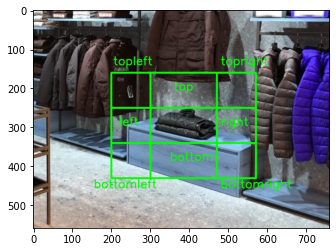

True

In [47]:
img = cv2.imread('/Users/danfengg/Downloads/2.jpg')
print(img.shape)
from matplotlib import pyplot as plt
cv2.rectangle(img,(850, 500), (1020, 590), (0,255,0), 4)
cv2.rectangle(img,(850, 410), (1020, 500), (0,255,0), 4)
cv2.putText(img, 'top', (910, 455), 0, 1, (0,255,0), 2)
cv2.rectangle(img,(850, 590), (1020, 680), (0,255,0), 4)
cv2.putText(img, 'bottom', (900, 635), 0, 1, (0,255,0), 2)
cv2.rectangle(img,(750, 500), (850, 590), (0,255,0), 4)
cv2.putText(img, 'left', (770, 545), 0, 1, (0,255,0), 2)
cv2.rectangle(img,(1020, 500), (1120, 590), (0,255,0), 4)
cv2.putText(img, 'right', (1030, 545), 0, 1, (0,255,0), 2)
cv2.rectangle(img,(750, 410), (850, 500), (0,255,0), 4)
cv2.putText(img, 'topleft', (755, 390), 0, 1, (0,255,0), 2)
cv2.rectangle(img,(1020, 410), (1120, 500), (0,255,0), 4)
cv2.putText(img, 'topright', (1030, 390), 0, 1, (0,255,0), 2)
cv2.rectangle(img,(750, 590), (850, 680), (0,255,0), 4)
cv2.putText(img, 'bottomleft', (705, 705), 0, 1, (0,255,0), 2)
cv2.rectangle(img,(1020, 590), (1120, 680), (0,255,0), 4)
cv2.putText(img, 'bottomright', (1030, 705), 0, 1, (0,255,0), 2)
img = img[250:,550:1310]
plt.imshow(img)
plt.show()
# cv2.rectangle(img,(left, top), (right, bottom), color, 2)
cv2.imwrite('/Users/danfengg/Downloads/cstore_2.jpg', img)

In [29]:
(850+1020)/2

935.0

In [109]:
len(k)

214

In [122]:
len(set(idr).intersection(set(idr2)))

67

In [80]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
tokenizer('[MASK]')

{'input_ids': [101, 103, 102], 'token_type_ids': [0, 0, 0], 'attention_mask': [1, 1, 1]}

In [115]:
r[1]['question']

'[USER] Show me some jeans which match my wardrobe, please. [SYS] What do you think of the jeans in the second row? The light blue jeans and the grey jeans. They match your wardrobe.  [USER] Add them both to my cart, would you? [SYS] Okay, both items will be added to your cart for you. [USER] Now, show me the customer review score for the light blue jeans. [SYS] Which ones are you talking about? [QRY] The ones that are in my cart. In between the grey pants and the camo pants.'

In [78]:
np.random.random([1,5])

array([[0.45721694, 0.80616934, 0.07299156, 0.36618756, 0.52177265]])

In [82]:
[1,2,3].index(2)

1